In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.9 MB/s eta 0:00:00


In [7]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fastparquet import write, ParquetFile

class NYCDataProcessor:
    def __init__(self, parquet_dir, shapefile_path, output_path):
        self.parquet_dir = parquet_dir
        self.shapefile_path = shapefile_path
        self.output_path = output_path
        self.full_df = None
        self.location_coords = None

    def load_shapefile(self):
        """Load the NYC shapefile and calculate centroids."""
        gdf = gpd.read_file(self.shapefile_path)
        gdf['centroid'] = gdf.geometry.centroid
        centroids_geo = gdf['centroid'].to_crs(epsg=4326)
        gdf['latitude'] = centroids_geo.y
        gdf['longitude'] = centroids_geo.x
        self.location_coords = gdf[['LocationID', 'latitude', 'longitude']]

    def preprocess_single_file(self, file):
        """Process a single Parquet file and append it to the output Parquet file."""
        # Read the Parquet file
        df = pd.read_parquet(os.path.join(self.parquet_dir, file))
        print(f"Processing {file}")
        # Standardize column names
        df.columns = [col.lower() for col in df.columns]
        print(df.columns)

        # Handle different versions of the `airport_fee` column
        if 'airport_fee' not in df.columns and 'airport_surcharge' in df.columns:
            df.rename(columns={'airport_surcharge': 'airport_fee'}, inplace=True)

        # Drop unwanted columns
        df.drop(['airport_fee', 'ratecodeid', 'congestion_surcharge'], axis=1, errors='ignore', inplace=True)

        # Drop NaN values
        df.dropna(subset=['passenger_count', 'store_and_fwd_flag'], inplace=True)

        # Merge pickup and dropoff locations
        df = df.merge(self.location_coords, left_on='pulocationid', right_on='LocationID', how='left')
        df.rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'}, inplace=True)
        df.drop('LocationID', axis=1, inplace=True)

        df = df.merge(self.location_coords, left_on='dolocationid', right_on='LocationID', how='left')
        df.rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'}, inplace=True)
        df.drop('LocationID', axis=1, inplace=True)

        # Drop rows with missing coordinates
        df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)

        # Add datetime features
        df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        df['pickup_day'] = df['pickup_datetime'].dt.day_name()
        df['dropoff_day'] = df['dropoff_datetime'].dt.day_name()
        df['pickup_day_no'] = df['pickup_datetime'].dt.weekday
        df['dropoff_day_no'] = df['dropoff_datetime'].dt.weekday
        df['pickup_hour'] = df['pickup_datetime'].dt.hour
        df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
        df['pickup_month'] = df['pickup_datetime'].dt.month
        df['dropoff_month'] = df['dropoff_datetime'].dt.month

        df['pickup_timeofday'] = df['pickup_hour'].apply(self.time_of_day)
        df['dropoff_timeofday'] = df['dropoff_hour'].apply(self.time_of_day)

        # Add calculated distance and duration
        df['distance_miles'] = self.haversine(
            df['pickup_latitude'], df['pickup_longitude'],
            df['dropoff_latitude'], df['dropoff_longitude']
        )
        df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

        # Add travel direction
        self.add_direction_feature(df)

        processed_path = os.path.join(self.output_path, 'full_df.parquet')
        if os.path.exists(processed_path):
                df.to_parquet(processed_path, index=False, compression='snappy', engine='fastparquet', append=True)
        else:
                df.to_parquet(processed_path, index=False, compression='snappy', engine='fastparquet')



    def preprocess_data(self):
        """Perform preprocessing on each Parquet file one by one and write to output."""
        self.load_shapefile()

        parquet_files = [f for f in os.listdir(self.parquet_dir) if f.endswith('.parquet')]
        for file in parquet_files:
            self.preprocess_single_file(file)

    def load_full_data(self):
        """Load the full processed dataset."""
        self.full_df = pd.read_parquet(self.output_path)

    @staticmethod
    def time_of_day(hour):
        """Convert an hour to a time of day category."""
        if hour in range(6, 12):
            return 'Morning'
        elif hour in range(12, 16):
            return 'Afternoon'
        elif hour in range(16, 22):
            return 'Evening'
        else:
            return 'Late night'

    @staticmethod
    def haversine(lat1, lon1, lat2, lon2):
        """Calculate the distance between two coordinates using the Haversine formula."""
        R = 3956.0  # Earth radius in miles
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c

    @staticmethod
    def ft_degree(lat1, lng1, lat2, lng2):
        """Calculate travel direction between two coordinates in degrees."""
        lng_delta_rad = np.radians(lng2 - lng1)
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        y = np.sin(lng_delta_rad) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
        return np.degrees(np.arctan2(y, x))

    @staticmethod
    def add_direction_feature(df):
        """Add a direction feature to the DataFrame based on travel direction."""
        df['direction'] = NYCDataProcessor.ft_degree(
            df['pickup_latitude'].values,
            df['pickup_longitude'].values,
            df['dropoff_latitude'].values,
            df['dropoff_longitude'].values
        )

    def visualize(self):
        """Create plots to visualize travel data."""
        if self.full_df is None:
            self.load_full_data()

        sns.countplot(x='passenger_count',data=self.full_df)

        figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
        ax1.set_title('Pickup Days')
        ax=sns.countplot(x="pickup_day",data=self.full_df,ax=ax1)
        ax2.set_title('Dropoff Days')
        ax=sns.countplot(x="dropoff_day",data=self.full_df,ax=ax2)

        figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))
        ax9.set_title('Pickup Days')
        ax=sns.countplot(x="pickup_hour",data=self.full_df,ax=ax9)
        ax10.set_title('Dropoff Days')
        ax=sns.countplot(x="dropoff_hour",data=self.full_df,ax=ax10)

        figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
        ax3.set_title('Pickup Time of Day')
        ax=sns.countplot(x="pickup_timeofday",data=self.full_df,ax=ax3)
        ax4.set_title('Dropoff Time of Day')
        ax=sns.countplot(x="dropoff_timeofday",data=self.full_df,ax=ax4)

        figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))
        ax11.set_title('Pickup Month')
        ax=sns.countplot(x="pickup_month",data=self.full_df,ax=ax11)
        ax12.set_title('Dropoff Month')
        ax=sns.countplot(x="dropoff_month",data=self.full_df,ax=ax12)


        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        fig.tight_layout(pad=5.0)

        sns.lineplot(x='pickup_day_no', y='distance_miles', data=self.full_df, ax=axs[0, 0])
        axs[0, 0].set_title('Distance by Day of Week')
        axs[0, 0].set_xlabel('Day of Week')
        axs[0, 0].set_ylabel('Distance (miles)')

        sns.lineplot(x='pickup_hour', y='distance_miles', data=self.full_df, ax=axs[0, 1])
        axs[0, 1].set_title('Distance by Pickup Hour')
        axs[0, 1].set_xlabel('Pickup Hour')
        axs[0, 1].set_ylabel('Distance (miles)')

        sns.lineplot(x='pickup_timeofday', y='distance_miles', data=self.full_df, ax=axs[1, 0])
        axs[1, 0].set_title('Distance by Time of Day')
        axs[1, 0].set_xlabel('Time of Day')
        axs[1, 0].set_ylabel('Distance (miles)')

        sns.lineplot(x='pickup_month', y='distance_miles', data=self.full_df, ax=axs[1, 1])
        axs[1, 1].set_title('Distance by Month')
        axs[1, 1].set_xlabel('Month')
        axs[1, 1].set_ylabel('Distance (miles)')

        plt.show()

        sns.relplot(y=self.full_df['distance_miles'], x='trip_duration', data=self.full_df)


    def visualize_2(self):
        """Create plots to visualize travel data."""
        if self.full_df is None:
            self.load_full_data()

        sns.countplot(x='passenger_count',data=self.full_df)

        figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
        ax1.set_title('Pickup Days')
        ax=sns.countplot(x="pickup_day",data=self.full_df,ax=ax1)
        ax2.set_title('Dropoff Days')
        ax=sns.countplot(x="dropoff_day",data=self.full_df,ax=ax2)

        figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))
        ax9.set_title('Pickup Days')
        ax=sns.countplot(x="pickup_hour",data=self.full_df,ax=ax9)
        ax10.set_title('Dropoff Days')
        ax=sns.countplot(x="dropoff_hour",data=self.full_df,ax=ax10)

        figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
        ax3.set_title('Pickup Time of Day')
        ax=sns.countplot(x="pickup_timeofday",data=self.full_df,ax=ax3)
        ax4.set_title('Dropoff Time of Day')
        ax=sns.countplot(x="dropoff_timeofday",data=self.full_df,ax=ax4)

        figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))
        ax11.set_title('Pickup Month')
        ax=sns.countplot(x="pickup_month",data=self.full_df,ax=ax11)
        ax12.set_title('Dropoff Month')
        ax=sns.countplot(x="dropoff_month",data=self.full_df,ax=ax12)


In [8]:
# Example Usage
parquet_dir = '/content/drive/MyDrive/dm_project/Divya/all_months'
shapefile_path = '/content/drive/MyDrive/dm_project/Divya/taxi_zones/taxi_zones.shp'
output_path = '/content/drive/MyDrive/dm_project/Divya/all_months/processed_data'

processor = NYCDataProcessor(parquet_dir, shapefile_path, output_path)
processor.preprocess_data()

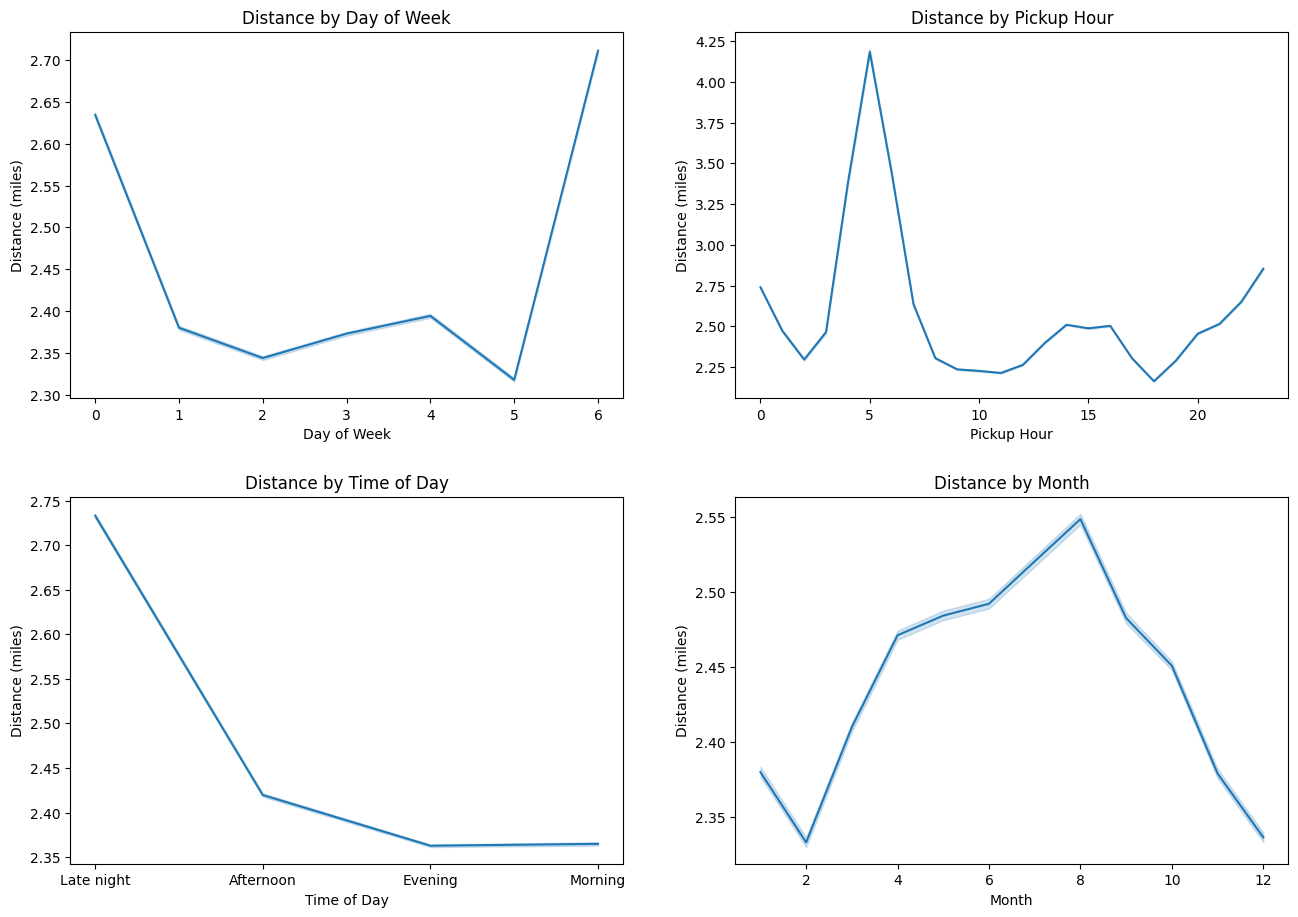

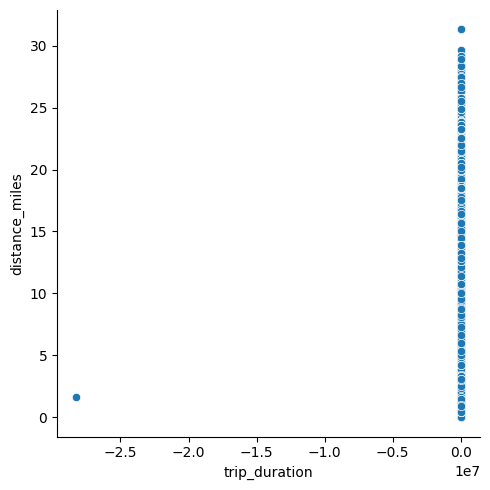

In [5]:
processor.visualize()

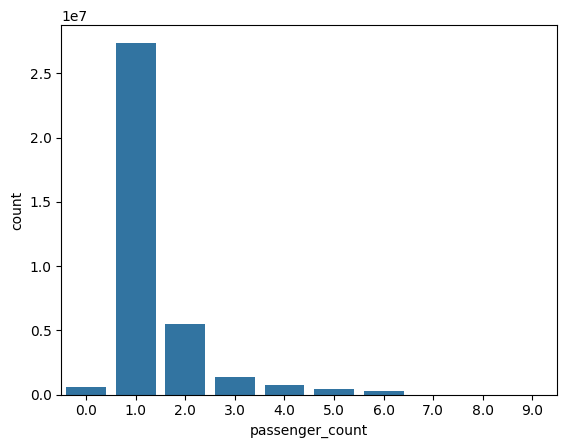

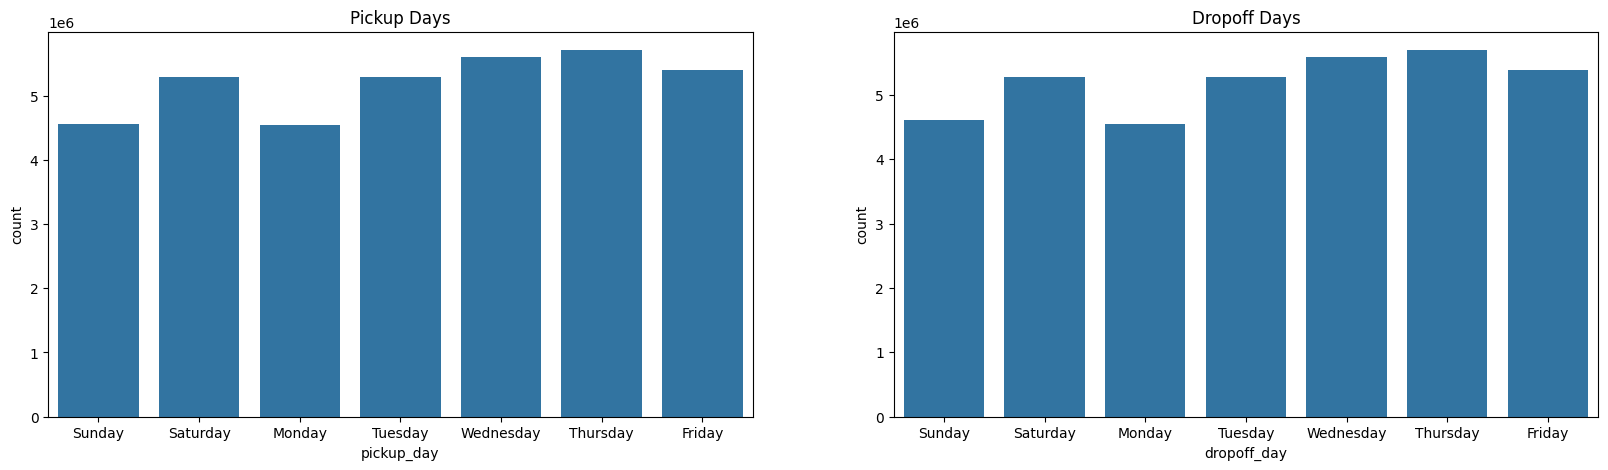

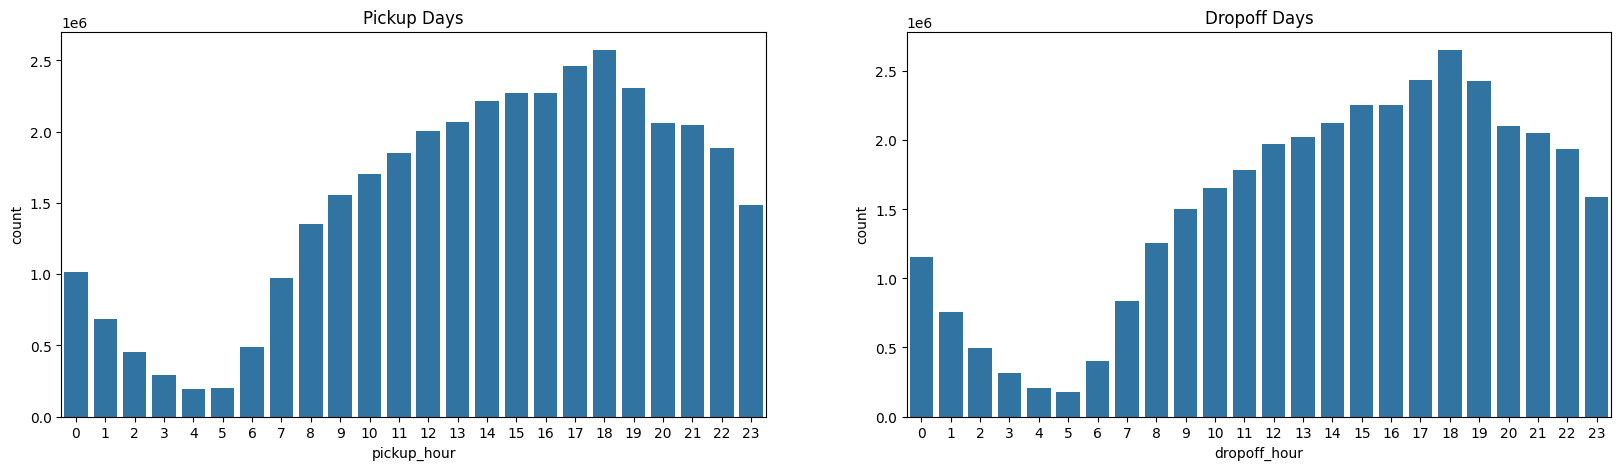

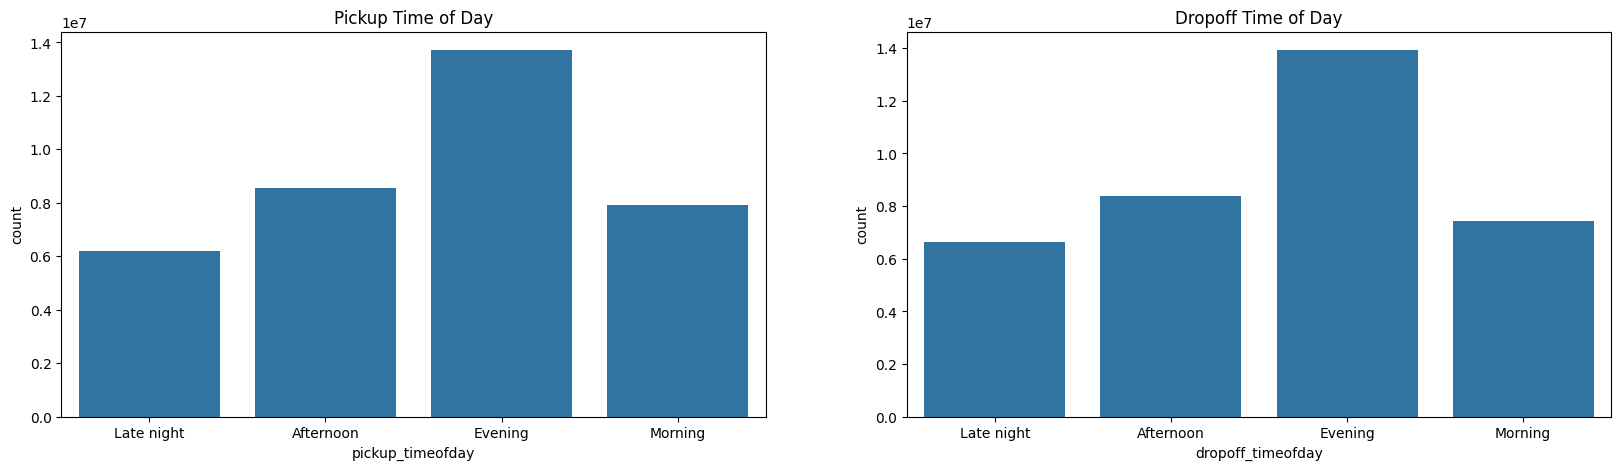

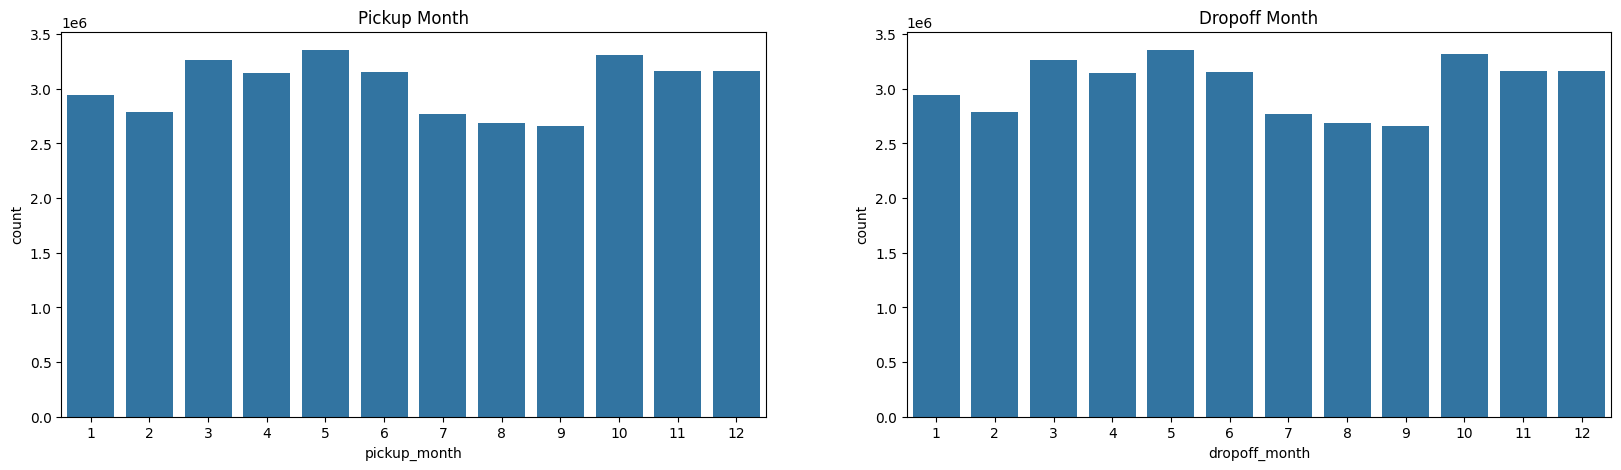

In [9]:

processor.visualize_2()